In [64]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.utils import dense_to_sparse
import networkx as nx
import matplotlib.pyplot as plt

In [65]:
start_date = '2015-01-01'
end_date = '2024-08-31'
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JPM', 'JNJ']

In [66]:
Apple = yf.download('AAPL', start=start_date, end=end_date, threads=False)
Microsoft = yf.download('MSFT', start=start_date, end=end_date, threads=False)
Amazon = yf.download('AMZN', start=start_date, end=end_date, threads=False)
Google = yf.download('GOOGL', start=start_date, end=end_date, threads=False)
Jonson = yf.download('JNJ', start=start_date, end=end_date, threads=False)
JPMorgan = yf.download('JPM', start=start_date, end=end_date, threads=False)

print(Apple.head())
print(Microsoft.head())
print(Amazon.head())
print(Google.head())
print(Jonson.head())
print(JPMorgan.head())

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347170  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661274  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663504  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995319  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917271  237458000
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  46.660000  47.419998  46.540001  46.759998  40.232857  27913900
2015-01-05  46.369999  46.730000  46.250000  46.330002  39.862869  39673900
2015-01-06  46.380001  46.750000  45.540001  45.650002  39.277802  36447900
2015-01-07  45.980000  46.459999  45.490002  46.230000  39.776833  29114100
2015-

In [67]:
tickers_name = [Apple,Microsoft,Amazon,Google,Jonson,JPMorgan]

In [68]:
print(Apple.isnull().sum())
print(Microsoft.isnull().sum())
print(Google.isnull().sum())
print(Amazon.isnull().sum())
print(Jonson.isnull().sum())
print(JPMorgan.isnull().sum())


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [69]:
Apple['AAPL_MA20'] = Apple['Adj Close'].rolling(window=20).mean()
Microsoft['MSFT_MA20'] = Microsoft['Adj Close'].rolling(window=20).mean()
Amazon['AMZN_MA20'] = Amazon['Adj Close'].rolling(window=20).mean()
Google['GOOGL_MA20'] = Google['Adj Close'].rolling(window=20).mean()
Jonson['JNJ_MA20'] = Jonson['Adj Close'].rolling(window=20).mean()
JPMorgan['JPM_MA20'] = JPMorgan['Adj Close'].rolling(window=20).mean()



# 50-day Moving Average
Apple['AAPL_MA50'] = Apple['Adj Close'].rolling(window=50).mean()
Microsoft['MSFT_MA50'] = Microsoft['Adj Close'].rolling(window=50).mean()
Amazon['AMZN_MA50'] = Amazon['Adj Close'].rolling(window=50).mean()
Google['GOOGL_MA50'] = Google['Adj Close'].rolling(window=50).mean()
Jonson['JNJ_MA50'] = Jonson['Adj Close'].rolling(window=50).mean()
JPMorgan['JPM_MA50'] = JPMorgan['Adj Close'].rolling(window=50).mean()

In [70]:
def compute_RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

Apple['AAPL_RSI14'] = compute_RSI(Apple['Adj Close'])
Microsoft['MSFT_RSI14'] = compute_RSI(Microsoft['Adj Close'])
Google['GOOGL_RSI14'] = compute_RSI(Google['Adj Close'])
Amazon['AMZN_RSI14'] = compute_RSI(Amazon['Adj Close'])
Jonson['JNJ_RSI14'] = compute_RSI(Jonson['Adj Close'])
JPMorgan['JPM_RSI14'] = compute_RSI(JPMorgan['Adj Close'])


In [71]:
def compute_MACD(series, span_short=12, span_long=26, span_signal=9):
    ema_short = series.ewm(span=span_short, adjust=False).mean()
    ema_long = series.ewm(span=span_long, adjust=False).mean()
    MACD = ema_short - ema_long
    signal = MACD.ewm(span=span_signal, adjust=False).mean()
    return MACD, signal

Apple['AAPL_MACD'], Apple['AAPL_MACD_Signal'] = compute_MACD(Apple['Adj Close'])
Microsoft['MSFT_MACD'], Microsoft['MSFT_MACD_Signal'] = compute_MACD(Microsoft['Adj Close'])
Amazon['AMZN_MACD'], Amazon['AMZN_MACD_Signal'] = compute_MACD(Amazon['Adj Close'])
Google['GOOGL_MACD'], Google['GOOGL_MACD_Signal'] = compute_MACD(Google['Adj Close'])
Jonson['JNJ_MACD'], Jonson['JNJ_MACD_Signal'] = compute_MACD(Jonson['Adj Close'])
JPMorgan['JPM_MACD'], JPMorgan['JPM_MACD_Signal'] = compute_MACD(JPMorgan['Adj Close'])


In [72]:
# Creating a 1-day lag feature
Apple['AAPL_Close_Lag1'] = Apple['Adj Close'].shift(1)
Microsoft['MSFT_Close_Lag1'] = Microsoft['Adj Close'].shift(1)
Amazon['AMZN_Close_Lag1'] = Amazon['Adj Close'].shift(1)
Google['GOOGL_Close_Lag1'] = Google['Adj Close'].shift(1)
Jonson['JNJ_Close_Lag1'] = Jonson['Adj Close'].shift(1)
JPMorgan['JPM_Close_Lag1'] = JPMorgan['Adj Close'].shift(1)

for lag in range(1, 6):
    Apple[f'AAPL_Close_Lag{lag}'] = Apple['Adj Close'].shift(lag)
    Microsoft[f'MSFT_Close_Lag{lag}'] = Microsoft['Adj Close'].shift(lag)
    Amazon[f'AMZN_Close_Lag{lag}'] = Amazon['Adj Close'].shift(lag)
    Google[f'GOOGL_Close_Lag{lag}'] = Google['Adj Close'].shift(lag)
    Jonson[f'JNJ_Close_Lag{lag}'] = Jonson['Adj Close'].shift(lag)
    JPMorgan[f'JPM_Close_Lag{lag}'] = JPMorgan['Adj Close'].shift(lag)


In [73]:
Apple.fillna({'AAPL_MA20':Apple['AAPL_MA20'].mean()}, inplace=True)
Microsoft.fillna({'MSFT_MA20':Microsoft['MSFT_MA20'].mean()}, inplace=True)
Amazon.fillna({'AMZN_MA20':Amazon['AMZN_MA20'].mean()}, inplace=True)
Google.fillna({'GOOGL_MA20':Google['GOOGL_MA20'].mean()}, inplace=True)
Jonson.fillna({'JNJ_MA20':Jonson['JNJ_MA20'].mean()}, inplace=True)
JPMorgan.fillna({'JPM_MA20':JPMorgan['JPM_MA20'].mean()}, inplace=True)
Apple.fillna({'AAPL_MA50':Apple['AAPL_MA50'].mean()}, inplace=True)
Microsoft.fillna({'MSFT_MA50':Microsoft['MSFT_MA50'].mean()}, inplace=True)
Amazon.fillna({'AMZN_MA50':Amazon['AMZN_MA50'].mean()}, inplace=True)
Google.fillna({'GOOGL_MA50':Google['GOOGL_MA50'].mean()}, inplace=True)
Jonson.fillna({'JNJ_MA50':Jonson['JNJ_MA50'].mean()}, inplace=True)
JPMorgan.fillna({'JPM_MA50':JPMorgan['JPM_MA50'].mean()}, inplace=True)
Apple.fillna({'AAPL_RSI14':Apple['AAPL_RSI14'].mean()}, inplace=True)
Microsoft.fillna({'MSFT_RSI14':Microsoft['MSFT_RSI14'].mean()}, inplace=True)
Amazon.fillna({'AMZN_RSI14':Amazon['AMZN_RSI14'].mean()}, inplace=True)
Google.fillna({'GOOGL_RSI14':Google['GOOGL_RSI14'].mean()}, inplace=True)
Jonson.fillna({'JNJ_RSI14':Jonson['JNJ_RSI14'].mean()}, inplace=True)
JPMorgan.fillna({'JPM_RSI14':JPMorgan['JPM_RSI14'].mean()}, inplace=True)
for lag in range(1, 6):
    Apple.fillna({f'AAPL_Close_Lag{lag}':Apple[f'AAPL_Close_Lag{lag}'].mean()}, inplace=True)
    Microsoft.fillna({f'MSFT_Close_Lag{lag}':Microsoft[f'MSFT_Close_Lag{lag}'].mean()}, inplace=True)
    Amazon.fillna({f'AMZN_Close_Lag{lag}':Amazon[f'AMZN_Close_Lag{lag}'].mean()}, inplace=True)
    Google.fillna({f'GOOGL_Close_Lag{lag}':Google[f'GOOGL_Close_Lag{lag}'].mean()}, inplace=True)
    Jonson.fillna({f'JNJ_Close_Lag{lag}':Jonson[f'JNJ_Close_Lag{lag}'].mean()}, inplace=True)
    JPMorgan.fillna({f'JPM_Close_Lag{lag}':JPMorgan[f'JPM_Close_Lag{lag}'].mean()}, inplace=True)

    

In [74]:
Apple.rename(columns={'Open': 'AAPL_Open', 'High': 'AAPL_High', 'Low': 'AAPL_Low', 'Close': 'AAPL_Close', 'Adj Close': 'AAPL_Adj Close', 'Volume': 'AAPL_Volume'}, inplace=True)
Microsoft.rename(columns={'Open': 'MSFT_Open', 'High': 'MSFT_High', 'Low': 'MSFT_Low', 'Close': 'MSFT_Close', 'Adj Close': 'MSFT_Adj Close', 'Volume': 'MSFT_Volume'}, inplace=True)
Amazon.rename(columns={'Open': 'AMZN_Open', 'High': 'AMZN_High', 'Low': 'AMZN_Low', 'Close': 'AMZN_Close', 'Adj Close': 'AMZN_Adj Close', 'Volume': 'AMZN_Volume'}, inplace=True)
Google.rename(columns={'Open': 'GOOGL_Open', 'High': 'GOOGL_High', 'Low': 'GOOGL_Low', 'Close': 'GOOGL_Close', 'Adj Close': 'GOOGL_Adj Close', 'Volume': 'GOOGL_Volume'}, inplace=True)
Jonson.rename(columns={'Open': 'JNJ_Open', 'High': 'JNJ_High', 'Low': 'JNJ_Low', 'Close': 'JNJ_Close', 'Adj Close': 'JNJ_Adj Close', 'Volume': 'JNJ_Volume'}, inplace=True)
JPMorgan.rename(columns={'Open': 'JPM_Open', 'High': 'JPM_High', 'Low': 'JPM_Low', 'Close': 'JPM_Close', 'Adj Close': 'JPM_Adj Close', 'Volume': 'JPM_Volume'}, inplace=True)

In [75]:
stocks = pd.concat([Apple,Microsoft,Amazon,Google,Jonson,JPMorgan],axis = 1)

In [76]:

# Concatenate all stocks' adjusted closing prices
stocks_prices = pd.concat([Apple['AAPL_Adj Close'], Microsoft['MSFT_Adj Close'], Amazon['AMZN_Adj Close'], 
                           Google['GOOGL_Adj Close'], Jonson['JNJ_Adj Close'], JPMorgan['JPM_Adj Close']], axis=1)

# Calculate the correlation matrix
correlation_matrix = stocks_prices.corr()

# Convert the correlation matrix into an adjacency matrix (thresholding for the edges)
threshold = 0.8  # You can adjust this threshold
adjacency_matrix = (correlation_matrix > threshold).astype(int)


In [77]:
features = stocks.drop('JPM_Adj Close',axis = 1)

In [78]:
features.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
features.fillna(0, inplace=True)

In [79]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [80]:
node_features = torch.tensor(features, dtype=torch.float)

In [81]:
# Convert adjacency matrix to a sparse format
adjacency_matrix_sparse = torch.tensor(adjacency_matrix.values, dtype=torch.float32)
edge_index, edge_attr = dense_to_sparse(adjacency_matrix_sparse)


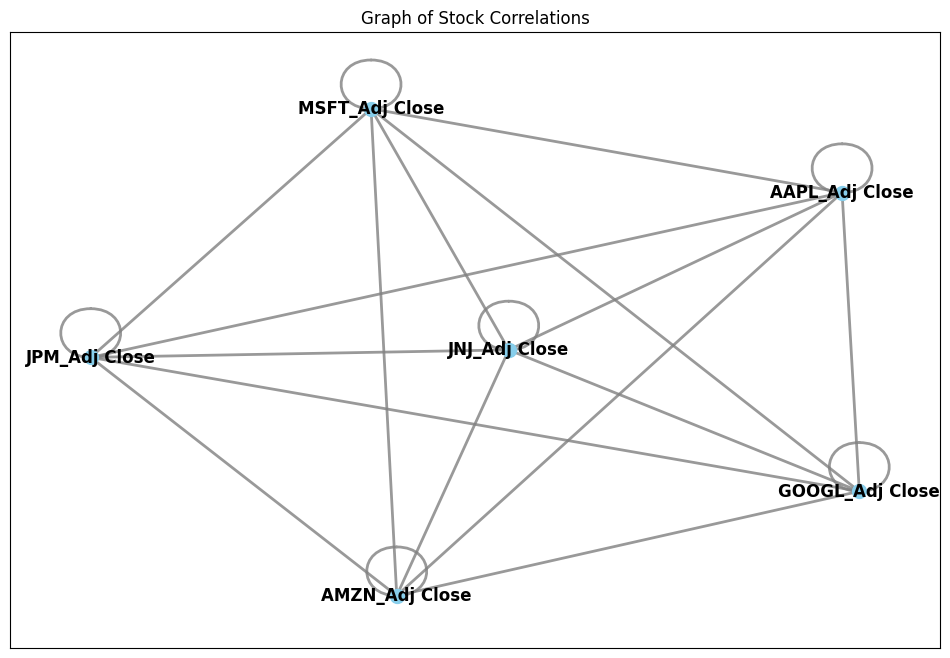

In [82]:
# Assuming `adjacency_matrix` is a Pandas DataFrame created earlier
# Convert stock ticker names to labels for each node in the graph
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'JPM']

# Create a NetworkX graph from the adjacency matrix
G = nx.from_pandas_adjacency(adjacency_matrix)

# Relabel the nodes to use stock tickers instead of numbers
mapping = {i: tickers[i] for i in range(len(tickers))}
G = nx.relabel_nodes(G, mapping)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=70)  # Layout for visual spacing

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(G, pos, node_size=100, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=2, alpha=0.8, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

plt.title("Graph of Stock Correlations")
plt.show()


In [83]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [84]:
# Assuming `stocks` is the DataFrame that contains your data, with columns like 'AAPL_Adj Close', 'MSFT_Adj Close', etc.
# Concatenate the adjusted close columns for all stocks to form the labels
labels = pd.DataFrame(stocks['JPM_Adj Close'])


In [85]:
# node_features.shape
labels.shape

(2432, 1)

In [86]:
input_dim = node_features.shape[1]
hidden_dim = 64
output_dim = labels.shape[1]  # Adjust to match the number of output labels
model = GNNModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.002)

In [87]:


# Convert `labels` DataFrame to NumPy array, then split the data
labels_array = labels.values  # Convert DataFrame to NumPy array

# Split data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(
    node_features, labels_array, test_size=0.2, random_state=False, shuffle=False
)

# Convert the train and validation sets to PyTorch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.float32)


C:\Users\akki1\AppData\Local\Temp\ipykernel_31384\1909275192.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32)
C:\Users\akki1\AppData\Local\Temp\ipykernel_31384\1909275192.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_features = torch.tensor(val_features, dtype=torch.float32)


In [88]:
num_epochs = 1800
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    train_outputs = model(train_features)
    train_loss = criterion(train_outputs, train_labels)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features)
        val_loss = criterion(val_outputs, val_labels)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}')

Epoch 1, Training Loss: 8940.2060546875, Validation Loss: 24788.447265625
Epoch 2, Training Loss: 8909.03125, Validation Loss: 24711.015625
Epoch 3, Training Loss: 8877.7080078125, Validation Loss: 24635.05859375
Epoch 4, Training Loss: 8846.5361328125, Validation Loss: 24562.16796875
Epoch 5, Training Loss: 8815.6064453125, Validation Loss: 24490.912109375
Epoch 6, Training Loss: 8784.9375, Validation Loss: 24419.630859375
Epoch 7, Training Loss: 8754.474609375, Validation Loss: 24345.466796875
Epoch 8, Training Loss: 8724.0078125, Validation Loss: 24266.71484375
Epoch 9, Training Loss: 8692.8154296875, Validation Loss: 24183.0390625
Epoch 10, Training Loss: 8660.2880859375, Validation Loss: 24094.55859375
Epoch 11, Training Loss: 8626.2216796875, Validation Loss: 24002.158203125
Epoch 12, Training Loss: 8590.61328125, Validation Loss: 23905.73828125
Epoch 13, Training Loss: 8553.56640625, Validation Loss: 23804.705078125
Epoch 14, Training Loss: 8515.1572265625, Validation Loss: 2369

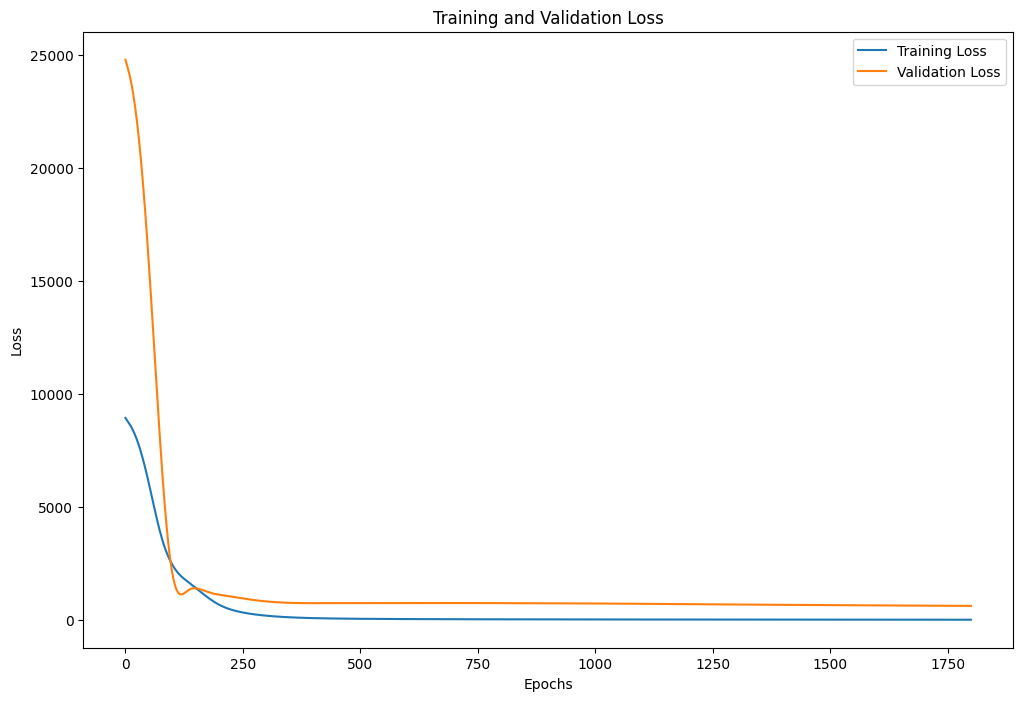

In [89]:
plt.figure(figsize=(12, 8))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [90]:
def evaluate_model(model, features, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(features)
        mse_loss = criterion(outputs, labels)
        mae_loss = torch.mean(torch.abs(outputs - labels))
        return outputs, mse_loss.item(), mae_loss.item()

In [91]:
train_outputs, train_mse, train_mae = evaluate_model(model, train_features, train_labels)
print(f"Training MSE Loss: {train_mse}, Training MAE: {train_mae}")

Training MSE Loss: 9.032387733459473, Training MAE: 2.3317794799804688


In [92]:
test_outputs, test_mse, test_mae = evaluate_model(model, val_features, val_labels)
print(f"Testing MSE Loss: {test_mse}, Testing MAE: {test_mae}")


Testing MSE Loss: 620.2916259765625, Testing MAE: 20.149682998657227


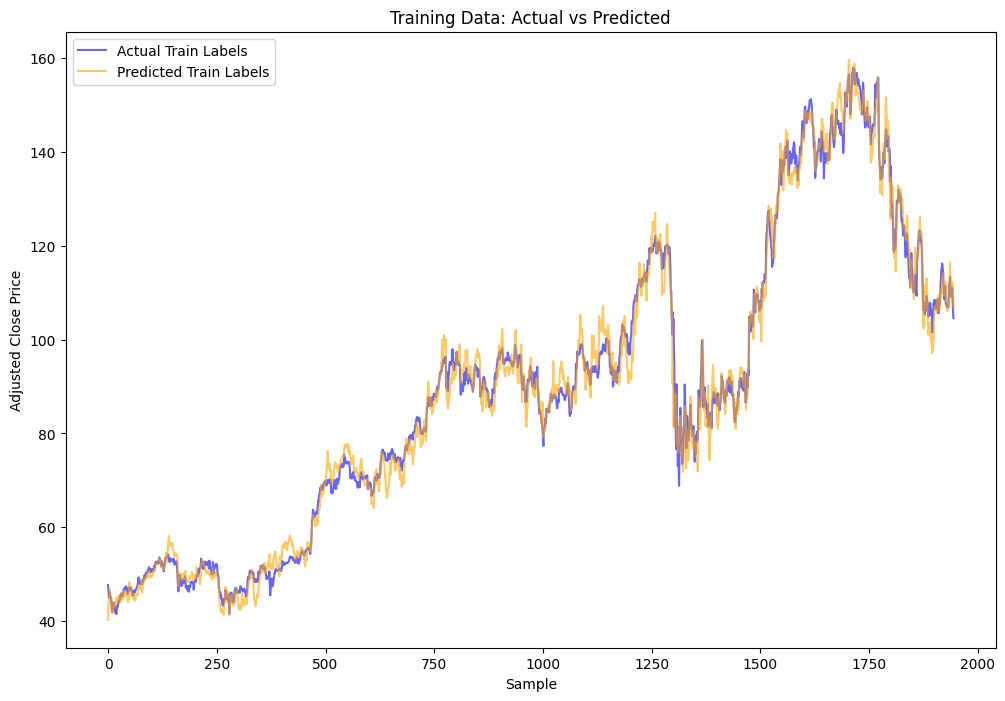

In [93]:
plt.figure(figsize=(12, 8))
plt.plot(train_labels.numpy()[:, 0], label='Actual Train Labels', color='blue', alpha=0.6)
plt.plot(train_outputs.numpy()[:, 0], label='Predicted Train Labels', color='orange', alpha=0.6)
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

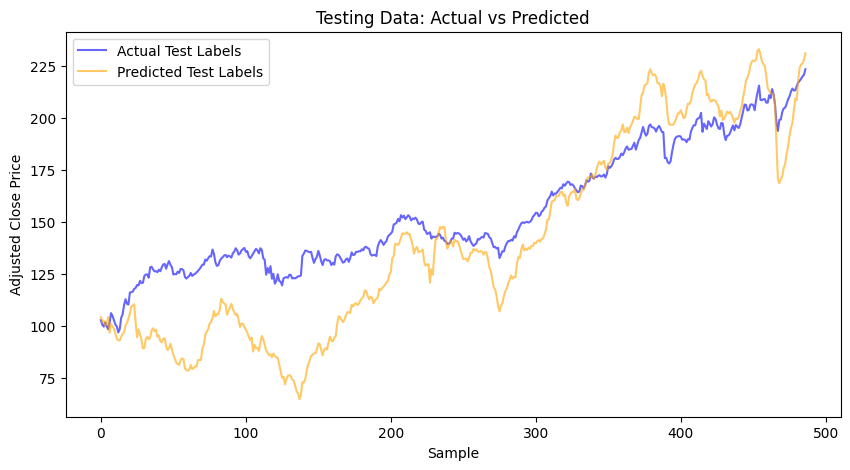

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(val_labels.numpy()[:, 0], label='Actual Test Labels', color='blue', alpha=0.6)
plt.plot(test_outputs.numpy()[:, 0], label='Predicted Test Labels', color='orange', alpha=0.6)
plt.title('Testing Data: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [95]:
import matplotlib.pyplot as plt

# Assuming `train_labels` and `train_predictions` are the actual and predicted prices for the training data
# and `val_labels` and `val_predictions` are the actual and predicted prices for the validation data
# Convert predictions to numpy arrays for plotting, if necessary
train_predictions = model(train_features).detach().numpy()
val_predictions = model(val_features).detach().numpy()

# Convert labels to numpy arrays if they are still tensors
train_labels_np = train_labels.numpy()
val_labels_np = val_labels.numpy()

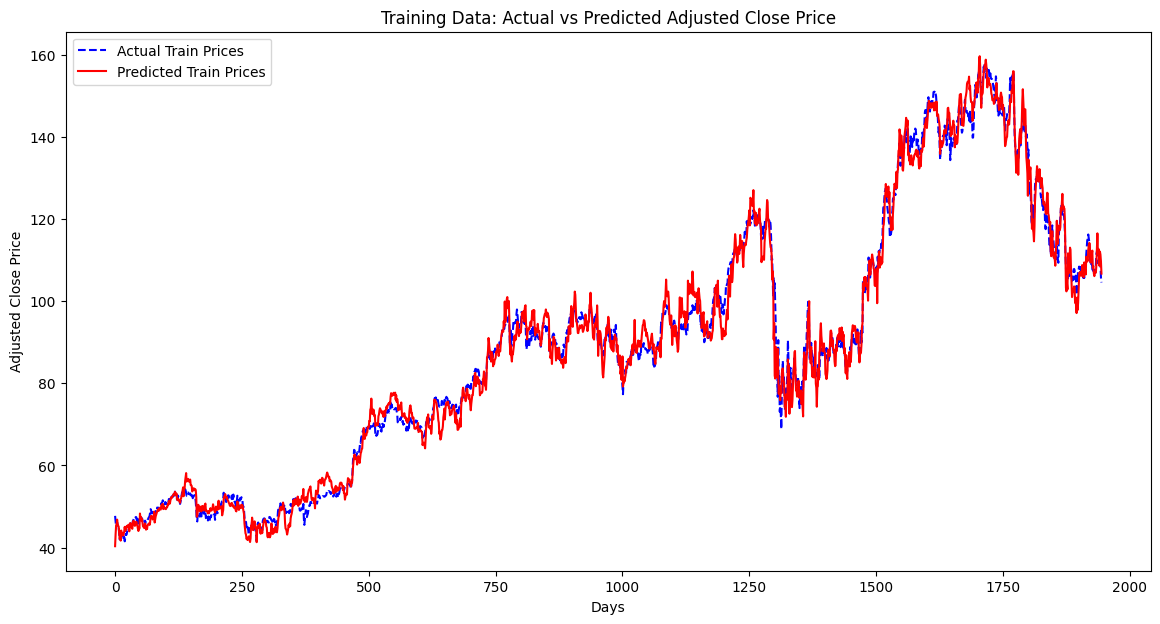

In [96]:
plt.figure(figsize=(14, 7))
plt.plot(train_labels_np, label="Actual Train Prices", color="blue", linestyle="dashed")
plt.plot(train_predictions, label="Predicted Train Prices", color="red")
plt.title("Training Data: Actual vs Predicted Adjusted Close Price")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

In [88]:
predicted = pd.DataFrame(val_predictions)

In [89]:
actual = pd.DataFrame(val_labels_np)

In [90]:
compare = pd.concat([actual,predicted],axis=1)

In [91]:
compare

,0,0
0,75.255356,74.865265
1,172.294708,191.149109
2,91.211754,90.113564
3,89.896904,85.328934
4,53.493931,45.573654
...,...,...
725,82.844124,65.979088
726,85.710876,82.768623
727,132.717499,136.300476
728,128.065720,103.682281


In [92]:
compare.head(20)

,0,0
0,75.255356,74.865265
1,172.294708,191.149109
2,91.211754,90.113564
3,89.896904,85.328934
4,53.493931,45.573654
5,215.190002,220.913208
6,85.586174,96.808830
7,109.102570,116.461433
8,68.751701,64.533485
9,47.197338,46.107754
